## Set up


In [ ]:
# @title Params {display-mode: "form"}
dest_dir = 'embeddings/' # @param   {type: "string", isTemplate: true}
data_dir = 'AP XML/' # @param   {type: "string", isTemplate: true}

In [ ]:
!mkdir -p $dest_dir

In [ ]:
# @title Import {display-mode: "form"}
import pandas as pd
import torch
import numpy as np
import tqdm
from transformers import pipeline
from transformers import BertConfig
from transformers import BertModel

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import random
import os.path
from os import path

from transformers import *
from collections import Counter

import math
import csv
import tqdm
import re
import os
import re

import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

## Find word occurrences

In [ ]:
def write_to_file(result, result_file):
    result.to_csv(result_file, mode='w', index=False)
    return pd.DataFrame()

def extract_global_dates(tree):
    root = tree.getroot() if tree.getroot() else tree
    date_elements = root.findall('.//titlePart/date')
    dates = [date.attrib['value'] for date in date_elements if 'value' in date.attrib]
    return dates

def write_data(keywords, elem, result, current_speaker, filename, date, year_sentence_count, year_limit=1500):
    data = elem.text
    if data:
        data = data.replace("\n", " ").strip()
        data = re.sub('\s{2,}', ' ', data)
        for sentence in re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', data):
            if len(sentence) > 512:
                continue
            for keyword in keywords:
                if keyword in sentence and re.search(r"\b" + keyword + r"\b", sentence):
                    year = date.split('-')[0] if date else None
                    if year_sentence_count[year] >= year_limit:
                        continue
                    result = result._append({
                        'keyword': keyword, 'sentence': sentence + ".",
                        'filename': filename, 'speaker': current_speaker,
                        'date': date, 'year': year
                    }, ignore_index=True)
                    year_sentence_count[year] += 1
    return result

def find_keywords(keywords, result_file, data_dir, limit = 5000):
    result = pd.DataFrame(columns=['keyword', 'sentence', 'filename', 'speaker', 'date'])
    year_sentence_count = {}
    for filename in os.listdir(data_dir):
        if filename == 'APvol71_table.xml':
            continue
        file_path = os.path.join(data_dir, filename)
        tree = ET.parse(file_path)
        dates = extract_global_dates(tree)
        current_speaker = "None"
        for elem in tree.iter():
            if elem.tag == 'p' or elem.tag == 'sp':
                for date in dates:
                    year = date.split('-')[0] if date else None
                    if year not in year_sentence_count:
                        year_sentence_count[year] = 0
                    result = write_data(keywords, elem, result, current_speaker, filename, date, year_sentence_count)
            if elem.tag == 'speaker':
                current_speaker = elem.text.strip() if elem.text else "None"

        if len(result) > limit:
            result = write_to_file(result, result_file)
            return result

    if len(result) > 0:
        write_to_file(result, result_file)

    return result


In [ ]:
keywords = ['Révolution', 'Révolutions', 'révolution', 'contre-révolution', 'contre-révolutions']
for k in keywords:
  keyword = [k]
  file_name = dest_dir + k + '_words_with_speaker.csv'
  result = find_keywords(keyword, file_name, data_dir)

## [Optional] Print Dataset Stats

### Entire data stats

In [ ]:
def process_documents(directory):
    stats = {}
    for filename in os.listdir(directory):
        if filename.endswith('.xml'):  # Process only XML files
            file_path = os.path.join(directory, filename)
            tree = ET.parse(file_path)
            dates = extract_global_dates(tree)  # Extract global dates from the document metadata
            current_speaker = "None"
            for elem in tree.iter():
                if elem.tag in ['p', 'sp']:
                    for date in dates:
                        year = date.split('-')[0] if date else None
                        if year not in stats:
                            stats[year] = {'total_words': 0, 'unique_speakers': set()}
                        if elem.text:
                            sentence = re.sub('[\n\s]+', ' ', elem.text.strip())
                            words = sentence.split()
                            stats[year]['total_words'] += len(words)
                            stats[year]['unique_speakers'].add(current_speaker)
                if elem.tag == 'speaker' and elem.text:
                    current_speaker = elem.text.strip()

    # Convert unique_speakers sets to counts
    for year in stats:
        stats[year]['unique_speakers'] = len(stats[year]['unique_speakers'])

    return stats

def extract_global_dates(tree):
    date_elements = tree.findall('.//titlePart/date')
    return [date.attrib['value'] for date in date_elements if 'value' in date.attrib]

In [ ]:
stats = process_documents(data_dir)
total_words = 0
unique_speakers = 0
for year, data in stats.items():
  total_words += data['total_words']
  unique_speakers += data['unique_speakers']
  print(f"Year: {year}")
  print(f"Total Words: {data['total_words']}")
  print(f"Unique Speakers: {data['unique_speakers']}")
  print()

print(f"Total Words: {total_words}")
print(f"Unique Speakers: {unique_speakers}")

Year: 1789
Total Words: 5081835
Unique Speakers: 1757

Year: 1790
Total Words: 10640605
Unique Speakers: 2236

Year: 1791
Total Words: 16225976
Unique Speakers: 2668

Year: 1792
Total Words: 10633752
Unique Speakers: 1681

Year: 1793
Total Words: 11877982
Unique Speakers: 1286

Total Words: 54460150
Unique Speakers: 9628


### Single Keyword Stats

In [ ]:
def count_total_words_and_speeches(df):
    df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))

    total_words = df['word_count'].sum()
    unique_speeches = len(df['speaker'].unique())

    summary = {
        'total_words': total_words,
        'unique_speeches': unique_speeches
    }

    return summary

word = 'Révolution'
file_name = dest_dir + word + '_words_with_speaker.csv'
data = pd.read_csv(file_name)
count_total_words_and_speeches(data)

NameError: name 'dest_dir' is not defined

### Visualize the data

In [ ]:
pd.set_option('display.max_colwidth', 0)
data = pd.read_csv(file_name)
data['sentence'] = data['sentence'].apply(lambda x: x.strip().replace("\n", " "))
data['sentence'] = data['sentence'].apply(lambda x: re.sub(' +', ' ', x))
data = data.drop_duplicates(subset='sentence')
data.to_csv(file_name)

In [ ]:
data.groupby('date').count()

,keyword,sentence,filename,speaker,year
date,,,,,
1789-05-05,6,6,6,6,6
1789-09-16,10,10,10,10,10
1793-04-13,76,76,76,75,76
1793-05-02,79,79,79,78,79
1793-06-03,64,64,64,64,64
1793-07-15,87,87,87,86,87
1793-07-30,108,108,108,107,108
1793-08-24,119,119,119,116,119
1793-09-12,92,92,92,89,92


In [ ]:
data

,keyword,sentence,filename,speaker,date,year
0,Révolution,"Lorsque nous n'avons pas le texte exact d'un discours dont l'auteur a joué un rôle important sous la Révolution, nous établissons le texte en coordonnant les journaux de l'époque, et pour permettre au lecteur de comparer les différences qui existent entre chacun d'eux, nous donnons en Annexe la version de ces divers journaux..",APvol62.xml,NaN,1793-04-13,1793
2,Révolution,"Comment, Marat aprè|s avoir peinti une partie de la Convention comme suspecte et ennemie de la Révolution, s'écrie : exterminons, sans pitié, tous les conspirateurs ; et l'on dira encore qu'il n'appelle pas le fer sur la tête d'une partie d'entre vous, sur les votants pour l'appel au peuple ou pour la, détention du tyran ou le sursis de son jugement !.",APvol62.xml,Delaunay,1793-04-13,1793
4,Révolution,"Examinez ensuite la conduite de ce citoyen, depuis la Révolution..",APvol62.xml,Delaunay,1793-04-13,1793
6,Révolution,"Attendu enfin que sans m'arrêter au style de Marat, ni à ses idées, je suis forcé de reconnaître en lui un des plus fermes appuis de la Révolution ; que ce citoyen a constamment dénoncé les traîtres et les plus grands conspirateurs, malgré les persécutions les plus fortes, je déclare en mon âme et conscience qu'il n'y a pas lieu à accusation..",APvol62.xml,Bentabole,1793-04-13,1793
8,Révolution,"Provoquons mutuellement la censure publique sur nos actions ; que chacun soit tenu de justifier de ce qu'il a fait pour le peuple avant et depuis la Révolution ; qu'il en soit fait uni tableau soumis à la contradiction des citoyens: alors le peuple distinguera ses vrais amis ; il ne sera plus dupe de ceux qui ne le flattent tant aujourd'hui, que pour mieux l'asservir: je me réserve d'en faire la motion expresse..",APvol62.xml,Bernier,1793-04-13,1793
...,...,...,...,...,...,...
2196,Révolution,"Vous penserez, Messieurs, que pour l'honneur de la nation française, pour le succès de cette Révolution, l'Assemblée doit prendre des précautions, pour mettre en sûreté les députés du clergé dont vous avez déclaré la personne inviolable et sacrée..",APvol9.xml,M. l'abbé Grégoire.,1789-09-16,1789
2198,Révolution,La Révolution qui a été commencée par le courage doit être achevée par la sagesse..,APvol9.xml,M. Bailly.,1789-09-16,1789
2200,Révolution,sur les suites de cette Révolution..,APvol9.xml,M. le Président,1789-09-16,1789
2202,Révolution,"Ils veulent en vain persuader aux peuples qne la dissolution de l'empire sera la suite de la Révolution : sans doute on doit s'attendre aux plus grands malheurs si les peuples ne se persuadent pas de la nécessité de rentrer dans l'ordre et dans l'obéissance aux lois ; mais, s'ils se laissaient séduire par les perfides avis qu'on ne cesse de leur donner, ils retomberaient bientôt dans l'esclavage lo plus abject, et sous le fléau d'un despotisme irrité des obstacles qu'il a éprouvés..",APvol9.xml,M. le Président,1789-09-16,1789


## Extract Embeddings

In [ ]:
class bert_model():
    def __init__(self, name):
        self.name = name
        self.config = BertConfig(output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained(name)
        self.object = BertModel.from_pretrained(name,
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

def get_id(key_word, tokenizer):
    tokenized_text = tokenizer.tokenize("[CLS] " + key_word + " [SEP]")
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    return indexed_tokens[1:-1]

def average_last_4(token_embeddings):
    token_vecs_cat = []

    for token in token_embeddings:
        #stack all into 2d array
        cat_vec = torch.stack((token[-1], token[-2], token[-3], token[-4]), dim=0)
        #take the average across columns
        cat_vec = torch.mean(cat_vec, 0)
        token_vecs_cat.append(cat_vec)
    return token_vecs_cat

def extract_word_embeddings_average(model, text, ids):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = model.tokenizer.tokenize(marked_text)
    indexed_tokens = model.tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.object.eval()

    with torch.no_grad():
        outputs = model.object(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]


    # WORD EMBEDDING
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    token_vecs_average_last_4 = average_last_4(token_embeddings)

    # Find where keyword is
    word_embedding = []
    try:
        #find the sequence
        #take the embedding of the first item in the sequence
        index = [(i, i+len(ids)) for i in range(len(indexed_tokens)) if indexed_tokens[i:i+len(ids)] == ids][0][0]
        word_embedding = token_vecs_average_last_4[index]

    except:
        word_embedding = None
        #dataset has Albanian instead of just Albania
        print("Skip sentence")
        return None, None

    # SENTENCE EMBEDDING
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    return word_embedding, sentence_embedding

def run_analysis(model, data, indices, ids):
    word_embeddings = []
    sentence_embeddings = []
    index_numbers = []
    for n, row in data.iterrows():
        word_embedding, sentence_embedding = extract_word_embeddings_average(model, row[0], ids)
        if (word_embedding is not None):
            word_embeddings.append(word_embedding)
            sentence_embeddings.append(sentence_embedding)
            index_numbers.append(indices[n])
            #if you found one, then you are good and can move on

    return word_embeddings, sentence_embeddings, index_numbers

def create_embeddings(filename, data):
    append_write = 'w' # make a new file if not
    with open(filename, append_write, newline='') as f:
        writer = csv.writer(f, delimiter=',')
        #change to keyword tag at times
        for name, group in data.groupby(['keyword']):
            print(name)
            #when group is not the same as keyword
            name_match = group['keyword'].values[0]
            ids = get_id(name_match, model_ml.tokenizer)
            word_embeddings, sentence_embeddings, row_numbers = run_analysis(model_ml, pd.DataFrame(group['sentence'].values), group['index'].values, ids)
            for word_embedding, sentence_embedding, row_number in zip(word_embeddings, sentence_embeddings, row_numbers):
                writer.writerow(word_embedding.tolist() + sentence_embedding.tolist() + [row_number] + [name] + [len(ids)])

def create_embeddings_masked(filename, data):
    append_write = 'w'
    with open(filename, append_write, newline='') as f:
        writer = csv.writer(f, delimiter=',')
        #change to keyword tag at times
        for n, row in data.iterrows():
            if (n % 100 == 0):
                print(n)
            word_embedding, sentence_embedding = extract_word_embeddings_average(model_ml, row['sentence'], ids)
            if (word_embedding is not None):
                writer.writerow(word_embedding.tolist() + sentence_embedding.tolist() + row.to_list() + [len(ids)])

In [ ]:
keywords = ['Révolution', 'Révolutions', 'révolution', 'contre-révolution', 'contre-révolutions']
for word in keywords:
  data = pd.read_csv(dest_dir + word + "_words_with_speaker.csv")
  data['sentence'] = data['sentence'].astype("str")
  data = data.reset_index()
  data['sentence'] = data['sentence'].str.strip()
  data = data[data['year'] != 'year']
  data['year'] = data['year'].astype(int)
  keywords = [word]

  data = data[data['keyword'].isin(keywords)]
  data['sentence'] = data['sentence'].apply(lambda x: re.sub(' +', ' ', x))
  model_bert_case = bert_model('bert-base-cased')
  model_ml = bert_model('bert-base-multilingual-cased')
  data = data.reset_index(drop=True)
  create_embeddings(dir + word + "_embeddings_with_speaker.csv", data)

  data['sentence'] = data.apply(lambda x: x['sentence'].replace(x['keyword'], "[MASK]"), axis=1)
  name_match = '[MASK]' #group['keyword'].values[0]
  ids = get_id(name_match, model_ml.tokenizer)

  create_embeddings_masked(dir + word + "_embeddings_with_speaker_masked.csv", data)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

('Révolution',)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

('Révolutions',)
0


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

('révolution',)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

('contre-révolution',)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

('contre-révolutions',)
0


## Word Confusion

### Generate data

In [ ]:
# Generate data
for word in ["révolution", "Révolution", "Révolutions", "contre-révolution", "contre-révolutions", "peuple", "personnes", "gouvernement", "conseil"]:
  embeddings = pd.read_csv(dir + word + "_embeddings_with_speaker.csv", header=None)
  sentences = pd.read_csv(dir + word + "_words_with_speaker.csv")
  embeddings = embeddings.set_index(1536).join(sentences.set_index(sentences.index))
  embeddings = embeddings.reset_index()
  embeddings['vol'] = embeddings['filename'].apply(lambda x: x.split(".")[0][5:])
  embeddings['vol'] = embeddings['vol'].astype(int)
  embeddings = embeddings.sample(frac=0.5, random_state=42)
  embeddings.to_csv(dir + word + "_embeddings_all_year.csv", mode='w', index=False)

### PCA + Classifier

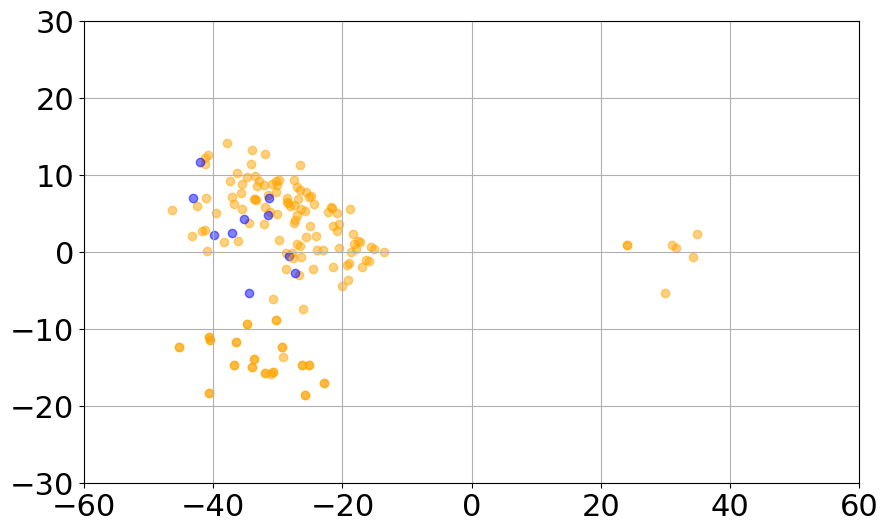

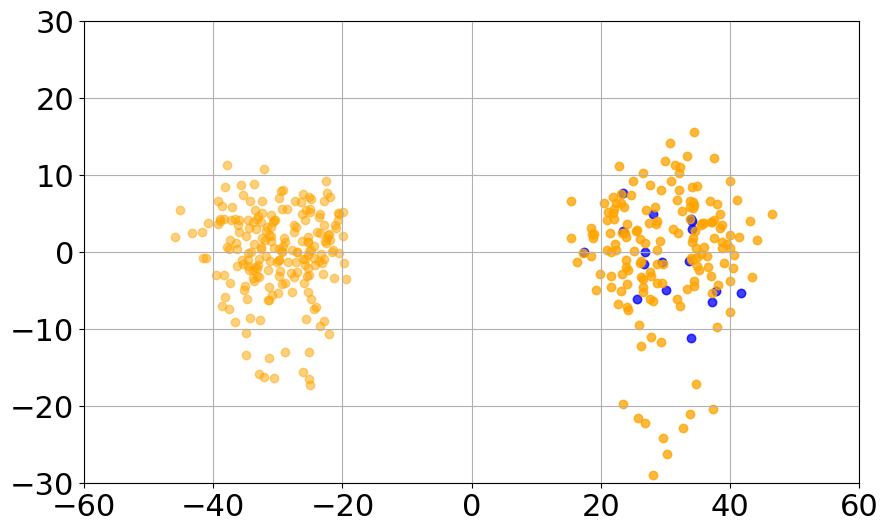

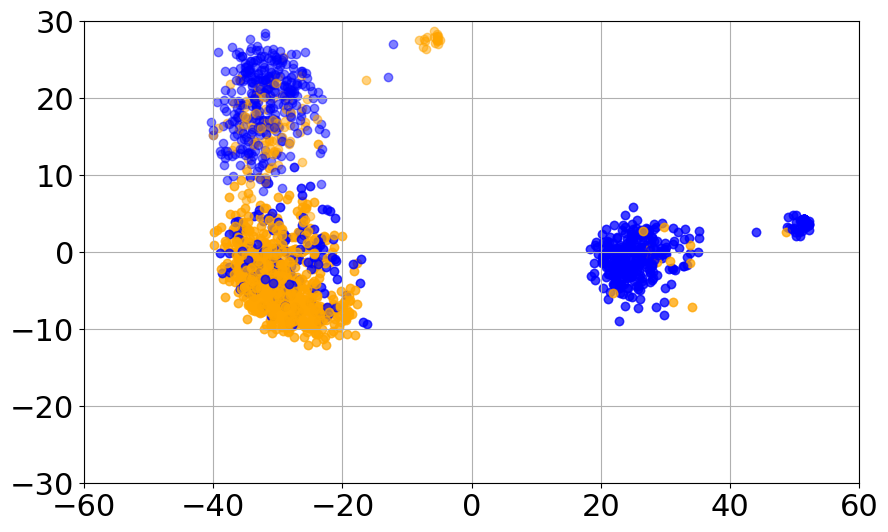

In [ ]:
contre = 'contre-révolution' # contre-révolution, contre-révolutions
revolution = 'révolution' # Révolution, Révolutions, révolution

df_contre_revolution = pd.concat([pd.read_csv(dir + contre + "_embeddings_all_year.csv"), pd.read_csv(dir + "contre-révolutions" + "_embeddings_all_year.csv")])
df_contre_revolution["keyword"] = contre
df_revolution = pd.concat([pd.read_csv(dir + "Révolution" + "_embeddings_all_year.csv"), pd.read_csv(dir + "Révolutions" + "_embeddings_all_year.csv"), pd.read_csv(dir + "révolution" + "_embeddings_all_year.csv")])
df_revolution["keyword"] = revolution

df_conseil = pd.concat([pd.read_csv(dir + "gouvernement" + "_embeddings_all_year.csv"), pd.read_csv(dir + "conseil" + "_embeddings_all_year.csv") ])
df_peuple = pd.concat([pd.read_csv(dir + "personnes" + "_embeddings_all_year.csv"), pd.read_csv(dir + "peuple" + "_embeddings_all_year.csv")])

df_combined = pd.concat([df_contre_revolution, df_revolution], ignore_index=True)

# Function to get the probability for a specific class
def get_class_probability(classifier, X, target_class):
    class_index = list(classifier.classes_).index(target_class)
    return classifier.predict_proba(X)[:, class_index]

grouped_combined = df_combined.groupby('year')
grouped_conseil = df_conseil.groupby('year')
grouped_peuple = df_peuple.groupby('year')

classifiers = {}

# Train classifiers for each year
for year in range(1789, 1794):
    if year in grouped_conseil.groups and year in grouped_peuple.groups:
        data_conseil = grouped_conseil.get_group(year)
        data_peuple = grouped_peuple.get_group(year)

        X = pd.concat([data_conseil.iloc[:, 0:768], data_peuple.iloc[:, 0:768]]).values
        Y = pd.concat([data_conseil['keyword'], data_peuple['keyword']]).values

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        classifier = LogisticRegression(max_iter=500)
        classifier.fit(X_train, Y_train)

        classifiers[year] = classifier

# Iterate through each year from 1789 to 1793.
for year in range(1789, 1794):
    if year in classifiers and year in grouped_combined.groups:
        classifier = classifiers[year]

        df_year = grouped_combined.get_group(year)
        embeddings = df_year.iloc[:, 0:768].values=

        # Predict classes for the embeddings
        predictions = classifier.predict(embeddings)

        keywords = df_year['keyword'].values

        contre_revolution_indices = keywords == contre
        contre_embeddings = embeddings[contre_revolution_indices]
        scaler_contre = StandardScaler()
        contre_embeddings_standardized = scaler_contre.fit_transform(contre_embeddings)

        revolution_indices = keywords == revolution
        revolution_embeddings = embeddings[revolution_indices]
        scaler_revolution = StandardScaler()
        revolution_embeddings_standardized = scaler_revolution.fit_transform(revolution_embeddings)

        embeddings_standardized = np.zeros_like(embeddings)
        embeddings_standardized[contre_revolution_indices] = contre_embeddings_standardized
        embeddings_standardized[revolution_indices] = revolution_embeddings_standardized

        # Apply PCA on the standardized embeddings
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(embeddings_standardized)

        mean_contre = pca_result[contre_revolution_indices, 0].mean()
        mean_revolution = pca_result[revolution_indices, 0].mean()

        ## Plotting
        # Determine if the groups are vertically aligned
        mean_contre_y = pca_result[contre_revolution_indices, 1].mean()
        mean_revolution_y = pca_result[revolution_indices, 1].mean()
        if abs(mean_revolution - mean_contre) < abs(mean_revolution_y - mean_contre_y):
            # Rotate the points 90 degrees
            pca_result = pca_result[:, [1, 0]]
        # Flip the PCA results to ensure contre is always at the right
        mean_contre = pca_result[contre_revolution_indices, 0].mean()
        mean_revolution = pca_result[revolution_indices, 0].mean()
        if mean_revolution > mean_contre:
            pca_result[:, 0] = -pca_result[:, 0]
        pca_result[revolution_indices, 0] -= 30
        pca_result[contre_revolution_indices, 0] += 30

        plt.figure(figsize=(10, 6))
        # Plot points based on the classifier prediction
        for i, keyword in enumerate(keywords):
            marker = 'o' if keyword == revolution else 'o'
            color = 'orange' if predictions[i] == 'personnes' or predictions[i] == 'peuple' else 'blue'
            plt.scatter(pca_result[i, 0], pca_result[i, 1], color=color, marker=marker, alpha=0.5)
        # Set the same x and y axis limits for consistency across plots
        plt.xlim([-60, 60])
        plt.ylim([-30, 30])
        plt.xticks(np.arange(-60, 61, 20))
        plt.yticks(np.arange(-30, 31, 10))
        plt.tick_params(axis='both', which='major', labelsize=14)  # Set tick font size to 14
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title(f'PCA of Embeddings for Year {year}')
        # Legend
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label="people"),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="government"),
        ]
        plt.legend(handles=handles)
        plt.grid(True)
        plt.show()
